### Most Clutch Kickers

two definitions of clutch (kicks to take lead, or increase score by more then two postions with less then 4 minutes in the 4th quarter)
- kickers who outpreform there general skill the most in clutch situations
- kickers who make the most clutch kicks

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Emory/NFL Lab/')

### load and clean

In [2]:
df = pd.read_csv('data/nfl_kick_attempts.csv')

In [3]:
# remove trailing spaces
df['kicker_player_name'] = df['kicker_player_name'].str.replace(' ', '')
df = df.drop_duplicates()

### ev of kicks

#### xp

In [4]:
xp = df[df['extra_point'] == 1]
xp_ev = xp.groupby(['season'])['made'].agg(['count', 'mean']).reset_index().rename(columns={'mean':'xp_ev'})
xp_ev['kick_type'] = 'XP'
print(xp_ev)

    season  count     xp_ev kick_type
0     1999   1059  0.988669        XP
1     2000   1053  0.990503        XP
2     2001   1027  0.981500        XP
3     2002   1170  0.981197        XP
4     2003   1130  0.982301        XP
5     2004   1191  0.989924        XP
6     2005   1116  0.984767        XP
7     2006   1138  0.987698        XP
8     2007   1182  0.985618        XP
9     2008   1180  0.991525        XP
10    2009   1187  0.981466        XP
11    2010   1217  0.988496        XP
12    2011   1207  0.994200        XP
13    2012   1237  0.993533        XP
14    2013   1267  0.996054        XP
15    2014   1231  0.992689        XP
16    2015   1217  0.941660        XP
17    2016   1195  0.936402        XP
18    2017   1134  0.940035        XP
19    2018   1235  0.942510        XP
20    2019   1210  0.938843        XP
21    2020   1338  0.929746        XP
22    2021   1257  0.933970        XP
23    2022   1187  0.946083        XP
24    2023   1169  0.958939        XP
25    2024  

In [5]:
df = df.merge(xp_ev, on=['season', 'kick_type'], how='left').drop(columns=['count'])

In [6]:
mask = df['extra_point'] == 1
df.loc[mask, 'xp_ev'] = df.loc[mask, 'made'] - df.loc[mask, 'xp_ev'] # ev of xp minus 1 to get added value 

#### fg

In [7]:
fg = df[df['extra_point'] == 0]
fg_ev = fg.groupby(['kick_distance', 'season'])['made'].agg(['count', 'mean']).reset_index()


weights = {0: 0.25, 1: 0.20, 2: 0.15}
default_weight = 0.1

def weighted_season_avg(group):
    results = []
    seasons = sorted(group['season'].unique())
    for season in seasons:
        weighted_sum = 0
        total_weight = 0
        for offset in range(0, -7, -1):
            target_season = season + offset
            weight = weights.get(offset, default_weight)
            match = group[group['season'] == target_season]
            if not match.empty:
                weighted_sum += match['mean'].values[0] * weight
                total_weight += weight
        avg = weighted_sum / total_weight if total_weight > 0 else np.nan
        results.append({'kick_distance': group['kick_distance'].iloc[0], 'season': season, 'weighted_mean': avg})
    return pd.DataFrame(results)

fg_ev_weighted = fg_ev.groupby('kick_distance', group_keys=False).apply(weighted_season_avg).reset_index(drop=True)
print(fg_ev_weighted.head())

   kick_distance  season  weighted_mean
0             18    1999            1.0
1             18    2000            1.0
2             18    2001            1.0
3             18    2002            1.0
4             18    2003            1.0


C:\Users\dalto\AppData\Local\Temp\ipykernel_20340\3837251224.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fg_ev_weighted = fg_ev.groupby('kick_distance', group_keys=False).apply(weighted_season_avg).reset_index(drop=True)


fit a curve

In [8]:
def polynomial_func(x, a, b, c):
        return a * x**2 + b * x + c

In [9]:
poly = []
for season in fg_ev_weighted['season']:
        fg_ev_fit = fg_ev_weighted[fg_ev_weighted['season'] == season]

        ppot, pcov = curve_fit(polynomial_func, fg_ev_fit['kick_distance'], fg_ev_fit['weighted_mean'], p0=[1, 0.5, 0])
        poly.append({
                'season': season,
                'ppot': ppot,
                'pcov': pcov
        })
poly = pd.DataFrame(poly)

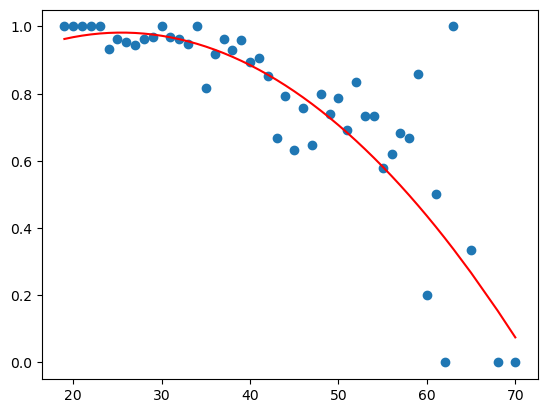

In [20]:
fg_ev_plt = fg_ev[fg_ev['season'] == 2024]
ppot_season = poly[poly['season'] == 2024]['ppot'].iloc[0]

plt.scatter(x=fg_ev_plt['kick_distance'], y=fg_ev_plt['mean'])
plt.plot(fg_ev_plt['kick_distance'], polynomial_func(fg_ev_plt['kick_distance'], *ppot_season), color='red')

In [11]:
mask = df['extra_point'] == 0
df['fg_prob'] = np.nan

for season in df['season'].unique():
    ppot_season = poly[poly['season'] == season]['ppot'].iloc[0]
    season_mask = df['season'] == season
    df.loc[season_mask, 'fg_prob'] = polynomial_func(df.loc[season_mask, 'kick_distance'], *ppot_season).clip(1, 0)

df.loc[mask, 'xp_ev'] = df.loc[mask, 'made'] - df.loc[mask, 'fg_prob']
df = df.rename(columns={'xp_ev': 'ev'})

### Average Preformance

In [12]:
df_avg_ev = df.groupby('kick_distance')['ev'].agg(['count', 'mean']).reset_index().rename(columns={'mean':'avg_ev_at_dist'})
df = df.merge(df_avg_ev, on=['kick_distance'], how='right')
df['ev_above_average'] = df['ev'] - df['avg_ev_at_dist']

best kickers by this

In [13]:
df_player = df.groupby(['kicker_player_id'])['ev_above_average'].agg(['sum', 'count', 'mean']).reset_index()
df_acc = df.groupby(['kicker_player_id'])['made'].agg(['mean']).reset_index()
df_acc = df_acc.rename(columns={'mean':'acc'})
df_player = df_player.merge(df_acc, on=['kicker_player_id'])
print(df_player['mean'].corr(df_player['acc']))

0.9425041502239284


### Stability

In [14]:
eligible_kickers = df.groupby('kicker_player_id').filter(lambda x: len(x) >= 30)

eligible_kickers_sorted = eligible_kickers.sort_values(by=['kicker_player_id', 'game_date'])

first_25_means = eligible_kickers_sorted.groupby('kicker_player_id')['ev_above_average'].apply(
    lambda group: group.head(15).sum()
).reset_index()

next_25_means = eligible_kickers_sorted.groupby('kicker_player_id')['ev_above_average'].apply(
    lambda group: group.iloc[15:30].sum()
).reset_index()

means = first_25_means.merge(next_25_means, on=['kicker_player_id'])

In [15]:
print(means['ev_above_average_x'].corr(means['ev_above_average_y']))

-0.003951666250792972


### Define Clutch Time

In [16]:
clutch_score_diff = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
close_game = [-2, -1, 1, 2]
df_clutch = df[((df['qtr'] == 4) & (df['quarter_seconds_remaining'] < 300) & (df['score_differential'].isin(clutch_score_diff))) | 
               ((df['qtr'] == 2) & (df['quarter_seconds_remaining'] < 120) & (df['score_differential'].isin(close_game)))]

df_clutch_player = df_clutch.groupby(['kicker_player_id'])['ev_above_average'].agg(['sum', 'mean', 'count'])
df_clutch_player_acc = df_clutch[df_clutch['extra_point'] == 0].groupby(['kicker_player_id'])['made'].agg(['mean']).rename(columns={'mean':'acc'})
df_clutch_player = df_clutch_player.merge(df_clutch_player_acc, on=['kicker_player_id']).rename(columns={'acc':'clutchK_acc', 'mean':'clutch_ev', 'count':'clutch_count', 'sum':'clutch_sum'}).reset_index()

In [17]:
df_player_compare = df_clutch_player.merge(df_player, on=['kicker_player_id'], how='right')
df_diff = pd.DataFrame()
df_diff['kicker_player_id'] = df_player_compare['kicker_player_id']
df_diff['clutch_count'] = df_player_compare['clutch_count']
df_diff['ev_diff'] = df_player_compare['clutch_ev'] - df_player_compare['mean']
df_diff['acc'] = df_player_compare['clutchK_acc'] - df_player_compare['acc']

In [18]:
df_diff = df_diff.merge(df[['kicker_player_id', 'kicker_player_name']], how='left').drop_duplicates()
df_diff = df_diff[df_diff['clutch_count'] > 5]
print(df_diff.nlargest(10, 'ev_diff'))
print(df_diff.nsmallest(10, 'ev_diff'))

      kicker_player_id  clutch_count   ev_diff       acc kicker_player_name
55453       00-0038402           9.0  0.175968  0.156863          A.Carlson
48524       00-0033138           7.0  0.136881  0.049451           S.Ficken
29246       00-0023635          13.0  0.134192  0.154762           D.Rayner
1923        00-0001343           7.0  0.129276  0.134146        C.Blanchard
55958       00-0039172           6.0  0.127090  0.062500            J.Bates
43437       00-0030390          22.0  0.109330  0.058021          C.Sturgis
46634       00-0031718           9.0  0.107388  0.104348           A.Franks
16683       00-0019490          35.0  0.107381  0.013548          P.Edinger
48248       00-0032870          13.0  0.105789  0.129808            A.Rosas
43149       00-0030332          18.0  0.075215 -0.017857            B.Maher
      kicker_player_id  clutch_count   ev_diff       acc kicker_player_name
55555       00-0038562           8.0 -0.345676 -0.495425            J.Moody
5600        

In [19]:
df_clutch_player = df_clutch_player.merge(df[['kicker_player_id', 'kicker_player_name']], how='left').drop_duplicates()
df_clutch_player = df_clutch_player[df_clutch_player['clutch_count'] > 5]
df_clutch_player = df_clutch_player.drop(columns=['kicker_player_id', 'clutch_sum'])
print(df_clutch_player.nlargest(10, 'clutch_ev'))
print(df_clutch_player.nsmallest(10, 'clutch_ev'))

       clutch_ev  clutch_count  clutchK_acc kicker_player_name
55460   0.149088             6     1.000000            J.Bates
1922    0.114024             7     1.000000        C.Blanchard
16482   0.112311            35     0.882353          P.Edinger
54955   0.110891             9     1.000000          A.Carlson
28949   0.092065            13     1.000000           D.Rayner
46232   0.085302             9     1.000000           A.Franks
12054   0.073225            38     0.894737           M.Stover
43068   0.072860            22     0.928571          C.Sturgis
47832   0.070426            13     1.000000            A.Rosas
12839   0.070159            35     0.857143       M.Vanderjagt
       clutch_ev  clutch_count  clutchK_acc kicker_player_name
55057  -0.372746             8     0.400000            J.Moody
37334  -0.170653             7     0.500000          D.Buehler
5483   -0.158250            11     0.666667         A.DelGreco
8311   -0.156683            11     0.500000           M